In [1]:
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import exp as exp
from numpy import sqrt as sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.size'] = 12
from scipy.optimize import curve_fit as cf

In [2]:
def Rs(t,p):
    t = t/180*np.pi
    p = p/180*np.pi
    return np.array([np.sin(t)*np.cos(p), np.sin(t)*np.sin(p), np.cos(t)])    

def Rx(tx):
    tx = tx/180*np.pi
    Rx = np.array([[1,0,0],
                   [0,np.cos(tx),-np.sin(tx)],
                   [0,np.sin(tx), np.cos(tx)]])
    return Rx

def Rz(tz):
    tz= tz/180*np.pi
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0],
                   [np.sin(tz), np.cos(tz), 0],
                   [0, 0, 1]])    
    return Rz

def boltzmann(gs, T):
    return np.exp(-6.26e-34*gs*1e9/(1.38e-23*T))

def coth(gs, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.tanh(h*gs*1e9/(2*kB*T))**(-1)

def lorentzian(nu, nu0, Gamma, A, c):
    return A*(Gamma/2)**2/((nu-nu0)**2+(Gamma/2)**2) + c 

def gaussian(nu, nu0, sigma, A, c):
    return A*1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(nu-nu0)**2/(2*sigma**2)) + c

### Orbital and Spin Basis States

In [3]:
# "Cartesian" Basis
egx = basis(4, 0)
egy = basis(4, 1)
eux = basis(4, 2)
euy = basis(4, 3)

# Spin-Orbit Basis
egp = 1/np.sqrt(2)*(egx + 1j*egy)
egm = 1/np.sqrt(2)*(egx - 1j*egy)
eup = 1/np.sqrt(2)*(eux + 1j*euy)
eum = 1/np.sqrt(2)*(eux - 1j*euy)

# Orbital Operators
Sgx = egx*egy.dag()
Sgx += Sgx.dag()
Sgy = -1j*egx*egy.dag()
Sgy += Sgy.dag()
Sgz = egx*egx.dag() - egy*egy.dag()
Sux = eux*euy.dag()
Sux += Sux.dag()
Suy = -1j*eux*euy.dag()
Suy += Suy.dag()
Suz = eux*eux.dag() - euy*euy.dag()

# Spin Staes and Operators
su = basis(2,0)
sd = basis(2,1)
Sx = su*sd.dag() + sd*su.dag()
Sy = -1j*su*sd.dag() + 1j*sd*su.dag()
Sz = su*su.dag() - sd*sd.dag()

### Orbital Dipole Operators

In [4]:
sigm_x = egp*eum.dag() + egm*eup.dag()
sigm_x = tensor(sigm_x, qeye(2))
sigp_x = sigm_x.dag()
px = sigm_x+sigp_x

sigm_y = 1j*egp*eum.dag() -1j* egm*eup.dag()
sigm_y = tensor(sigm_y, qeye(2))
sigp_y = sigm_y.dag()
py = sigm_y+sigp_y

sigm_z = 2*(egp*eup.dag() + egm*eum.dag())
sigm_z = tensor(sigm_z, qeye(2))
sigp_z = sigm_z.dag()
pz = sigm_z + sigp_z

### System Parameters

In [67]:
h = 6.626e-34
c = 299792458
e = 1.62e-19
T = 5

# Bare coulomb splitting of Eg and Eu states
w_C = 2*pi*c/736.85

# Spin-orbit couplings
lbd_SO_g = 2*pi*46
lbd_SO_u = 2*pi*250

# (Transverse) Strain couplings
alpha_g = 2*pi*500
beta_g = 2*pi*500

alpha_u = 2*pi*1.8/1.3*alpha_g
beta_u = 2*pi*2*beta_g

# Magnetons and gyromagnetic ratio for electron and nuclear spin
muB = 2*pi*9.274e-24/h * 1e-9
muN = 2*pi*5.505e-23/h * 1e-9
g_e = 2
g_n = 1.910*0

# Orbital angular momentum quenching factor (phenomenological)
q = 0.15

# SiV orientation (theta, phi) with respect to external lab frame, where z defines the optical axis
# theta_x = 54.7 and theta_z = 45 corresponds to a <111> crystal direction
theta_x = 54.7
theta_z = 45

# We can use a transformation matrix which transforms coordinates such that 111 --> 001, i.e. in this reference
# frame the SiV symmetry axis is pointing along z
Rz(-theta_z)@Rx(-theta_x)[:,2]

array([0.57709642, 0.57709642, 0.57785762])

### Hamiltonian

In [79]:
def Hamiltonian(B, alpha, beta):
    # Coulomb interaction 
    HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))

    # Spin-Orbit interaction
    HSO = -lbd_SO_g/2 * tensor(Sgy,Sz) - lbd_SO_u/2 * tensor(Suy,Sz)

    # Magnetic field unit vectors with B_theta and B_phi relative angels to SiV symmetry axis
    B_theta, B_phi = 0, 0
    Bmag = 0.3
    bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)

    # Orbital and Spin interaction
    HZS = g_e * muB/2 * tensor(qeye(4), (Sx * bx + Sy * by + Sz * bz)) * Bmag
    HZL = q * muB * bz * Bmag * tensor((Sgy + Suy), qeye(2))

    # Strain interaction
    HStr = tensor(alpha_g*Sgz + beta_g*Sgx + alpha_u*Suz + beta_g*Sux, qeye(2))


    H = HC + HSO + HZS + HZL + HStr    
    H = H.tidyup(1e-10)
    
    return H

### Collapse Operators

In [69]:
T = 5
gs = 46
T1_spin = 1000
T1_opt = 1.7

# 40ns is measured @5K and 46GHz ground-state splitting
T1_orb = (46/gs)**3*40

Gamma1_orb = 1/(1+boltzmann(gs,T))*1/(2*pi*T1_orb)    
Gamma1_orb_em = Gamma1_orb
Gamma1_orb_abs = boltzmann(gs, T) * Gamma1_orb_em
Gamma1_opt = 1/(2*pi*T1_opt)
Gamma1_spin = 1/(2*pi*T1_spin)

c_ops = [
    sqrt(Gamma1_opt)*sigm_x,
    sqrt(Gamma1_opt)*sigm_y,
    sqrt(Gamma1_opt)*sigm_z,
    sqrt(Gamma1_orb_em)*(tensor(egp*egm.dag(),su*su.dag()) + tensor(egm*egp.dag(), sd*sd.dag())),
    sqrt(Gamma1_orb_abs)*(tensor(egm*egp.dag(),su*su.dag()) + tensor(egp*egm.dag(), sd*sd.dag())),
    sqrt(Gamma1_spin)*tensor(qeye(4), sd*su.dag()),
    sqrt(Gamma1_spin)*tensor(qeye(4), su*sd.dag())
]

### Spectrum

In [77]:
def calc_transitions(H):
    trans_engs = np.zeros(H.shape)
    trans_dipoles = np.zeros(H.shape)

    engs_ = H.eigenstates()[0]
    evs_ = H.eigenstates()[1]

    for i, engi in enumerate(engs_):
        for j, engj in enumerate(engs_[:i]):         
            if round(abs(engi-engj),3)<1e4: continue
            trans_engs[i,j] = abs(engi-engj)
            trans_dipoles[i,j] = abs((evs_[i].dag() * px * evs_[j])[0,0])**2 + abs((evs_[i].dag() * py * evs_[j])[0,0])**2 + abs((evs_[i].dag() * pz * evs_[j])[0,0])**2

    # transitions = list(sorted(set(trans_engs[trans_engs.nonzero()])))
    transitions = np.array(list(sorted(trans_engs[trans_engs.nonzero()])))

    D = transitions[0*len(transitions)//4:1*len(transitions)//4]
    C = transitions[1*len(transitions)//4:2*len(transitions)//4]
    B = transitions[2*len(transitions)//4:3*len(transitions)//4]
    A = transitions[3*len(transitions)//4:4*len(transitions)//4]
    
    return A, B, C, D

def calc_spec(H, c_ops, transition, Omega_L, eps_L=[1,1,1]):
    eps_x, eps_y, eps_z = eps_L

    w_Ls = np.linspace(-100+np.amin(transition), np.amax(transition)+100, 200)
    pops = np.zeros((len(w_Ls), 4))
    for i, w_L in enumerate(w_Ls):    

        Hint = Omega_L/2*(eps_x*px + eps_y*py + eps_z*pz) - (w_L)/2 * HC/(w_C/2)
        Hint = Hint.tidyup()

        rho_ss = steadystate(H+Hint, c_ops)

        pops[i,0] = np.real(rho_ss[4,4])
        pops[i,1] = np.real(rho_ss[5,5])
        pops[i,2] = np.real(rho_ss[6,6])
        pops[i,3] = np.real(rho_ss[7,7])
    return w_Ls, pops

H = Hamiltonian()
A, B, C, D = calc_transitions(H)
w_Ls, pops = calc_spec(H, c_ops, C, Omega_L=1)

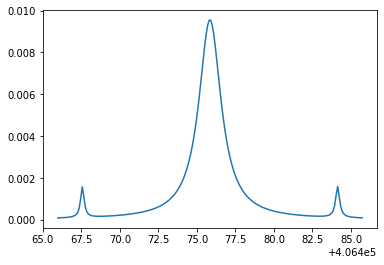

In [49]:
plt.plot(w_Ls/(2*pi), np.sum(pops, axis=1))